# 9_Sales_Funnel_and_A_A_B_Test_Analysis

<a id='back'><a/>
# Table of Contents
    
- [1. Sales Funnel and A/A/B Test Analysis Overview](#1)
- [2. General Information Overview](#2)
- [3. Data Preprocessing](#3)
- [4. Exploratory Data Analysis](#4)
    - [4.1 Users in Event Logs](#4.1)
    - [4.2 Time Period Covered](#4.2)
- [5. Event Funnel Analysis](#5)
    - [5.1 Event Log Frequency](#5.1)
    - [5.2 Users Performing Each Event](#5.2)
    - [5.3 Event Funnel](#5.3)
- [6. Experiment Results](#6)
    - [6.1 Statistical Difference Between Control Groups](#6.1)
    - [6.2 Statistical Differences in Experiments for the Different Events](#6.2)  
        - [6.2.1 Test for Control Groups 246 and 247](#6.2.1)
        - [6.2.2 Test for Control Groups Against Test Group 248](#6.2.2)
    - [6.3 Conclusion](#6.3) 
- [7. General Conclusion](#7)

<a id='1'><a/>
# 1. Sales Funnel and A/A/B Test Analysis Overview
[Return to Table of Contents](#back)

A startup selling food products is evaluating a change to its app. The startup's designers would like to change the fonts for the entire app, but the managers are concerned that users might find the new design intimidating. They have decided to make their decision based on the results of an A/A/B test. The app's users were split into three groups: two control groups (named 246 and 247) would get the old fonts and one test group (248) would get the new fonts. Our task it to study the user behavior, including understanding the sales funnel and the results of the A/A/B test, amongst for these groups to determine which fonts produce better results.

<a id='2'><a/>
# 2. General Information Overview
[Return to Table of Contents](#back)

In [1]:
# import libraries

import pandas as pd
from scipy import stats as stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math as mth

In [2]:
# read all input data

try: # local path
    df= pd.read_csv('logs_exp_us.csv','\t')
except: # server path
    df= pd.read_csv('/datasets/logs_exp_us.csv','\t')

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 22.9 MB


In [5]:
# getting a sense for how many users appear in each event and experiment

df.groupby('EventName')['ExpId'].value_counts()

EventName                ExpId
CartScreenAppear         248      15342
                         246      14819
                         247      12570
MainScreenAppear         248      41214
                         247      39710
                         246      38281
OffersScreenAppear       248      16571
                         247      15344
                         246      14910
PaymentScreenSuccessful  248      12242
                         246      11970
                         247      10101
Tutorial                 248        378
                         247        350
                         246        324
Name: ExpId, dtype: int64

In [6]:
df.duplicated().sum()

413

In [7]:
df.isnull().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In this file we have 244,000 log entries for different user actions (or events). The file contains event names, unique user identifiers, event times, and experiment numbers (246 and 247 are the control groups and 248 is the test group). There are 413 duplicates, but as the number is such a small piece of the sample, we will drop them. There are no missing values. We will do some work to make the information more presentable / workable (i.e. rename the columns, improve the event names, and convert the timestamp from epoch to datetime). 

<a id='3'><a/>
# 3. Data Preprocessing
[Return to Table of Contents](#back)

In [8]:
# renaming columns

df.columns = ['event','user_id','timestamp','experiment_id']

In [9]:
# making name of event types clearer

event_dict = {'CartScreenAppear':'Cart Screen',
'MainScreenAppear':'Main Screen',
'OffersScreenAppear': 'Offers Screen',
'PaymentScreenSuccessful': 'Payment Success Screen',
'Tutorial': 'Tutorial'}

df['event'].replace(event_dict, inplace=True)

In [10]:
# converting epoch time to datetime

df['timestamp'] = pd.to_datetime(df['timestamp'],unit="s")

In [11]:
# creating a new column with just the event date

df['event_date'] = df['timestamp'].astype('datetime64[D]')

In [12]:
# dropping the 413 duplicates

df = df.drop_duplicates()

The files that we were provided were largely uniform and complete. There were 413 duplicates that were dropped. There were no missing values. The data was made more presentable / workable (i.e. rename the columns, improve the event names, and convert the timestamp from epoch to datetime).

<a id='4'><a/>
# 4. Exploratory Data Analysis
[Return to Table of Contents](#back)

<a id='4.1'><a/>
## 4.1 Users in Event Logs
[Return to Table of Contents](#back)

In [13]:
# number of events in the logs

number_of_events = df['event'].count()

print('There are {} events in the logs.'.format(number_of_events))

There are 243713 events in the logs.


In [14]:
# number of users in the logs

number_of_users = df['user_id'].nunique()

print('There are {} unique users in the logs.'.format(number_of_users))

There are 7551 unique users in the logs.


In [15]:
# average number of events per user

events_per_user = number_of_events / number_of_users

print('There are on average {:.0f} events per user in the logs.'.format(events_per_user))

There are on average 32 events per user in the logs.


<a id='4.2'><a/>
## 4.2 Time Period Covered
[Return to Table of Contents](#back)

In [16]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

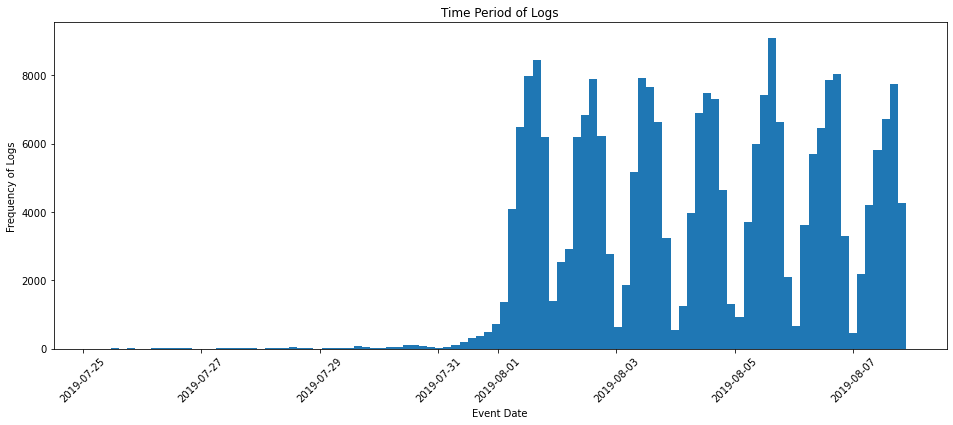

In [17]:
# timeperiod covered

df['timestamp'].hist(figsize=(16, 6), grid=False, bins=100)
plt.title('Time Period of Logs')
plt.xlabel('Event Date')
plt.ylabel('Frequency of Logs')
plt.xticks(rotation=45)
plt.show()

In the logs, events take place from July 25 to August 7th. However, we can see that most logs started on August 1st. We should consider dropping all dates prior. This may have been the result of a technical error.

In [18]:
# creating a new df dropping dates before 08/01/2019

new_df = df[df['event_date'] > '2019-07-31']

In [19]:
print('Only {} logs were lost after dropping everything before 08/01/2019.'.format(len(df) - len(new_df)))
print('Only {} users were lost after dropping everything before 08/01/2019.'.format(df['user_id'].nunique() - new_df['user_id'].nunique()))

Only 2826 logs were lost after dropping everything before 08/01/2019.
Only 17 users were lost after dropping everything before 08/01/2019.


In [20]:
# check to make sure that after our data drop there are still unique users for each experiment conducted

unique_users_per_experiment = new_df.groupby('experiment_id')['user_id'].nunique().to_frame().reset_index()
unique_users_per_experiment.columns = ['experiment_id','all_unique_users']
unique_users_per_experiment

,experiment_id,all_unique_users
0,246,2484
1,247,2513
2,248,2537


There are 243713 events in the logs with 7551 unique users. There are on average 32 events per user in the logs. Events place from July 25 to August 7th. However, since most logs started on August 1st we dropped all data prior. This deletion did not have a material impact on our analysis as Only 2826 logs and 17 users were lost. All experiments still had significant users following the drop.

<a id='5'><a/>
# 5. Event Funnel Analysis
[Return to Table of Contents](#back)

<a id='5.1'><a/>
## 5.1 Event Log Frequency
[Return to Table of Contents](#back)

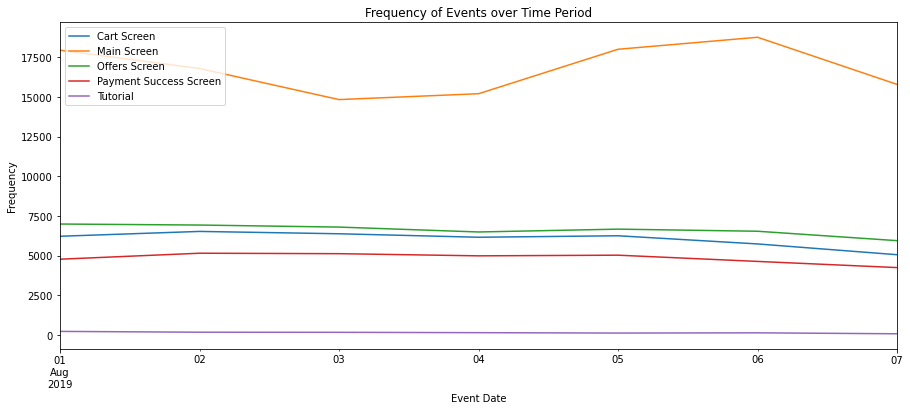

In [21]:
# what events are in the logs and their frequency of occurrence

new_df.groupby(['event_date','event']).count().drop(['timestamp','experiment_id'],axis=1).unstack(1).plot(figsize=(15, 6))

plt.title('Frequency of Events over Time Period')
plt.xlabel('Event Date')
plt.ylabel('Frequency')
plt.legend(['Cart Screen','Main Screen','Offers Screen','Payment Success Screen','Tutorial'], loc='upper left')
plt.show()

<a id='5.2'><a/>
## 5.2 Users Performing Each Event
[Return to Table of Contents](#back)

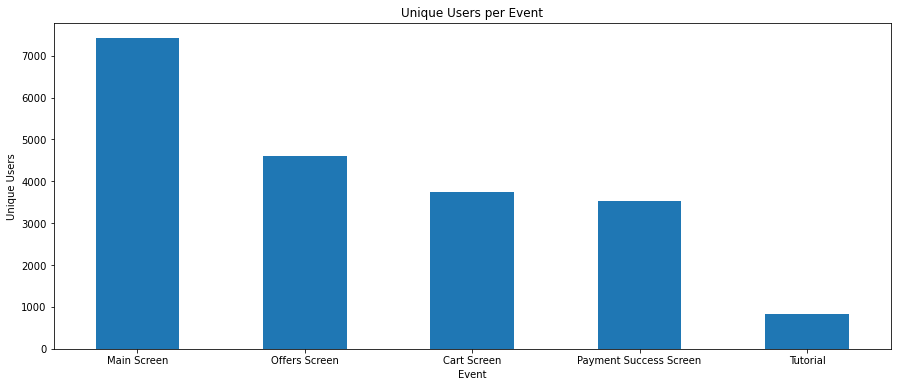

In [22]:
# the number of users who performed each of these actions

new_df.groupby('event')['user_id'].nunique().sort_values(ascending=False).plot(kind='bar',rot=0,figsize=(15, 6))

plt.title('Unique Users per Event')
plt.xlabel('Event')
plt.ylabel('Unique Users')
plt.show()

In [23]:
# proportion of users who performed the action at least once

all_users = new_df.groupby('event')['user_id'].count()
unique_users = new_df.groupby('event')['user_id'].nunique()
user_proportion = pd.concat([all_users, unique_users], axis=1).reset_index()
user_proportion.columns = ['event','all_users','unique_users']
user_proportion['percentage_one_time'] = user_proportion['unique_users'] / user_proportion['all_users']nb
user_proportion

SyntaxError: invalid syntax (<ipython-input-23-88f66607b73c>, line 7)

<a id='5.3'><a/>
## 5.3 Event Funnel
[Return to Table of Contents](#back)

In [ ]:
# order that events took place

from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = ["Main Screen","Offers Screen", "Cart Screen", "Payment Success Screen"],
    x = [7419, 4593, 3734, 3539]
    ))
fig.show() 

The frequency of events for all experiments was relatively stable over the time period, with some modest fluctuation for Main Screen, which also happens to be the event that occurs first and the most. It is after this event that the most users are lost (only 39.5% of users continue from "Main Screen" to "Offers Screen". 28.9% of users make the entire journey to the "Payment Success Screen". It is important to note that "Tutorial" was not included as this event was likely on the "Main Screen" (i.e. it took occurred sequentially).

<a id='6'><a/>
# 6. Experiment Results
[Return to Table of Contents](#back)

In [ ]:
# unique users in each group

unique_users_per_experiment

For the experiements to follow, these definitions apply unless otherwise specified:

<ul>
 <li>H0 (null hypothesis): the number of users in Experiment 1 = the number of users in Experiment 2; </li>
 <li>H1 (alternative hypothesis): the number of users in Experiment 1 <> the number of users in Experiment 2 </li>
 <li>Alpha: 0.05 </li>
 </ul>
 
If p_value < alpha, reject the null hypothesis. If p_value > alpha, fail to reject the null hypothesis.

<a id='6.1'><a/>
## 6.1 Statistical Difference Between Control Groups (246 and 247)
[Return to Table of Contents](#back)

In [ ]:
alpha = 0.05
A1_date = new_df[new_df['experiment_id']==246].groupby('event_date')[['user_id']].nunique()
A2_date = new_df[new_df['experiment_id']==247].groupby('event_date')[['user_id']].nunique()

In [ ]:
results_AA = stats.ttest_ind(A1_date['user_id'],A2_date['user_id'])
print('p-value for comparison of groups A1 and A2:',results_AA.pvalue)

In [ ]:
if (results_AA.pvalue < alpha):
    print("Null hypothesis rejected. There is a statistically significant difference between samples 246 and 247.")
else:
    print("Null hypothesis not rejected. There is no statistically significant difference between samples 246 and 247.")

<a id='6.2'><a/>
## 6.2 Statistical Differences in Experiments for the Different Events
[Return to Table of Contents](#back)

In [24]:
new_df.head()

,event,user_id,timestamp,experiment_id,event_date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,Main Screen,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,Main Screen,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,Offers Screen,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,Main Screen,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


In [28]:
exp_unique = new_df.pivot_table(index='event', values='user_id', columns='experiment_id', aggfunc=lambda x: x.nunique()).reset_index()

exp_unique

experiment_id,event,246,247,248
0,Cart Screen,1266,1238,1230
1,Main Screen,2450,2476,2493
2,Offers Screen,1542,1520,1531
3,Payment Success Screen,1200,1158,1181
4,Tutorial,278,283,279


In [ ]:
# for each of the experiments, the number of users who performed an event

exp_unique = new_df.pivot_table(index='event', values='user_id', columns='experiment_id', aggfunc=lambda x: x.nunique()).reset_index()

# function for statistical significance for each experiment and event

def hypothesis(experiment_id_1, experiment_id_2, alpha):
    print("For experiments", experiment_id_1, "and", experiment_id_2,"and with an alpha of",alpha,":" '\n')
    
    # for every event
    for event in exp_unique.event.unique():

        # define successes 
        success1 = exp_unique[exp_unique.event == event][experiment_id_1].iloc[0]
        success2 = exp_unique[exp_unique.event == event][experiment_id_2].iloc[0]

        # define trials
        trial1 = unique_users_per_experiment[unique_users_per_experiment.experiment_id == experiment_id_1]['all_unique_users'].iloc[0]
        trial2 = unique_users_per_experiment[unique_users_per_experiment.experiment_id == experiment_id_2]['all_unique_users'].iloc[0]

        # proportion for success in experiment 1
        p1 = success1 / trial1

        # proportion for success in experiment 2
        p2 = success2 / trial2

        # success proportion in the combined dataset
        combined_data = (success1 + success2) / (trial1 + trial2)

        # the difference between the datasets' proportions
        difference = p1 - p2
        
        # calculating the statistic in standard deviations of the standard normal distribution
        z_value = difference / mth.sqrt(combined_data * (1 - combined_data) * (1/trial1 + 1/trial2))

        ## setting up the standard normal distribution (mean 0, standard deviation 1)
        distr = stats.norm(0,1)
        
        # calculate p_value
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p_value: ', p_value)
        if (p_value < alpha):
            print(event,": Rejecting the null hypotheseis: there is a significant difference between the proportions" '\n')
        else:
            print(event,": Failed to reject the null hypothesis: there is no reason to consider the proportions different" '\n')
            
            

<a id='6.2.1'><a/>
### 6.2.1 Test for Control Groups 246 and 247
[Return to Table of Contents](#back)

In [ ]:
# test hypotheses about the equality of proportions of populations for experiments 246 and 247 (control groups)

hypothesis(246, 247, 0.05)

In [ ]:
# using 0.1 as the alpha

hypothesis(246, 247, 0.1)

After testing the equality of proportions of populations for experiments 246 and 247 with all results indicating that the null hypothesis failed to be rejected, we can confirm that the groups were split properly. 

<a id='6.2.2'><a/>
### 6.2.2 Test for Control Groups Against Test Group 248
[Return to Table of Contents](#back)

In [ ]:
# test hypotheses about the equality of proportions of populations for experiments 246 and 248

hypothesis(246, 248, 0.05)

In [ ]:
hypothesis(247, 248, 0.05)

Performing this same test with the experiment group of altered fonts, we see across the board that there is no reason to consider the proportions different. We can thus conclude that the differences in users amongst the different events are not significant.

In [ ]:
# using 0.1 as the alpha

hypothesis(246, 248, 0.1)

In [ ]:
# using 0.1 as the alpha

hypothesis(247, 248, 0.1)

With a statistical significance level of 0.1, one in 10 of the results above turned out to false. The result in question was for experiments 246 and 248, the Cart Screen. There was a significant difference in the two populations, meaning that the altered font did have an impact.

<a id='6.3'><a/>
## 6.3 Conclusion
[Return to Table of Contents](#back)

As a first step, we ran a test to determine the statistical significance between the number of users for the control groups and determined that there is no statistically significant difference between samples 246 and 247. Following that, we needed to test the statistical significance for the various events in for just the control groups. In total, 16 statistical hypothesis tests were run. Again, all results indicated that the null hypothesis failed to be rejected, allowing us to confirm that the groups were split properly. Finally, we performed this same test for the isolated control groups against the test group (248). Using an alpha of 0.05, we saw across the board that there was no reason to consider the proportions different, thus concluding that the differences in users amongst the different events are not significant. However, when the alpha was changed to 0.1, one in 10 of the results turned out to false. The result in question was for experiments 246 and 248, the Cart Screen. There was a significant difference in the two populations, meaning that the altered font did have an impact.

<a id='7'><a/>
# 7. General Conclusion
[Return to Table of Contents](#back)

**Data Processing**

The files that we were provided were largely uniform and complete. In this file we had 244,000 log entries for different user actions (or events). The file contains event names, unique user identifiers, event times, and experiment numbers (246 and 247 are the control groups and 248 is the test group). There were 413 duplicates that were dropped. There were no missing values.

**Exploratory Data Analysis**

There are 243713 events in the logs with 7551 unique users. There are on average 32 events per user in the logs. Events place from July 25 to August 7th. However, since most logs started on August 1st we dropped all data prior. This deletion did not have a material impact on our analysis as Only 2826 logs and 17 users were lost. All experiments still had significant users following the drop. 

**Event Funnel Analysis**

The frequency of events for all experiments was relatively stable over the time period, with some modest fluctuation for Main Screen, which also happens to be the event that occurs first and the most. It is after this event that the most users are lost (only 39.5% of users continue from "Main Screen" to "Offers Screen". 28%% of users make the entire journey to the "Payment Success Screen". It is important to note that "Tutorial" was not included as this event was likely on the "Main Screen" (i.e. it took occurred sequentially). 

**Experiment Results**

As a first step, we ran a test to determine the statistical significance between the number of users for the control groups and determined that there is no statistically significant difference between samples 246 and 247. Following that, we needed to test the statistical significance for the various events in for just the control groups. In total, 16 statistical hypothesis tests were run. Again, all results indicated that the null hypothesis failed to be rejected, allowing us to confirm that the groups were split properly. Finally, we performed this same test for the isolated control groups against the test group (248). Using an alpha of 0.05, we saw across the board that there was no reason to consider the proportions different, thus concluding that the differences in users amongst the different events are not significant. However, when the alpha was changed to 0.1, one in 10 of the results turned out to false. The result in question was for experiments 246 and 248, the Cart Screen. There was a significant difference in the two populations, meaning that the altered font did have an impact.